# Dijkstra's Algorithm

Source code based from https://www.datacamp.com/tutorial/dijkstra-algorithm-in-python

In [25]:
from heapq import heapify, heappop, heappush

def generate_neighbors(matrix, coords):
    x, y = coords
    neighbors = []

    # top
    neighbors.append((x - 1, y - 1))
    neighbors.append((x, y - 1))
    neighbors.append((x + 1, y - 1))

    # middle
    neighbors.append((x - 1, y))
    neighbors.append((x + 1, y))

    # bottom
    neighbors.append((x - 1, y + 1))
    neighbors.append((x, y + 1))
    neighbors.append((x + 1, y + 1))

    return [n for n in neighbors if 0 <= n[0] < len(matrix) and 0 <= n[1] < len(matrix[0])]

def shortest_distances(matrix, coords, weight_function):
    # generate neighbors
    neighbors = generate_neighbors(matrix, coords)
    distances = {}

    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            distances[(i, j)] = float("inf")

    distances[coords] = 0  # Set the source value to 0

    # Initialize a priority queue
    pq = [(0, coords)]
    heapify(pq)

    # Create a set to hold visited nodes
    visited = set()

    while pq:  # While the priority queue isn't empty
        current_distance, current_node = heappop(pq)

        if current_node in visited:
            continue 

        visited.add(current_node)

        for neighbor in generate_neighbors(matrix, current_node):
            weight = weight_function(matrix, current_node, neighbor)

            # Calculate the distance from current_node to the neighbor
            tentative_distance = current_distance + weight
            if tentative_distance < distances[neighbor]:
                distances[neighbor] = tentative_distance
                heappush(pq, (tentative_distance, neighbor))
    
    predecessors = {}
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            predecessors[(i, j)] = None

    for node, distance in distances.items():
        for neighbor in generate_neighbors(matrix, node):
            weight = weight_function(matrix, node, neighbor)
            
            if distances[neighbor] == distance + weight:
                predecessors[neighbor] = node

    return distances, predecessors

def shortest_path(matrix, src, dst, weight_func):
    # Generate the predecessors dict
    distances, predecessors = shortest_distances(matrix, src, weight_func)
    print(distances)
    path = []
    current_node = dst

    # Backtrack from the target node using predecessors
    while current_node != src:
        
        path.append(current_node)
        current_node = predecessors[current_node]

    path.append(src)

    # Reverse the path and return it
    path.reverse()

    return distances[dst], path
    

# Matrix Generation
Helper functions for:
* plotting the graphs with and without a path, 
* generating random starting position,
* interpolating the matrix, and
* finding the global minima


In [26]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage

from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

def generate_matrix():
    return np.random.rand(25, 25)

# 2D map code from https://matplotlib.org/stable/gallery/images_contours_and_fields/pcolormesh_levels.html#pcolormesh

def generate_2d_map(m):
    x = np.arange(0, 25)
    y = np.arange(0, 25)
    X, Y = np.meshgrid(x, y)

    fig, ax = plt.subplots()
    ax.pcolormesh(X, Y, m)

    plt.show()

# 3D Map code from https://matplotlib.org/stable/gallery/mplot3d/surface3d.html#sphx-glr-gallery-mplot3d-surface3d-py

def generate_3d_map(m):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    # Make data.
    X = np.arange(0, 25)
    Y = np.arange(0, 25)
    X, Y = np.meshgrid(X, Y)
    Z = m

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.magma,
                        linewidth=0, antialiased=False)

    # Customize the z axis.
    ax.set_zlim(0, 1)
    ax.zaxis.set_major_locator(LinearLocator(10))
    # A StrMethodFormatter is used automatically
    ax.zaxis.set_major_formatter('{x:.02f}')

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()

# Plotting line in graph from https://stackoverflow.com/questions/66172720/how-to-plot-a-numpy-array-over-a-pcolor-image-in-matplotlib

# top-view of row-column grid
def generate_rc_map(m, path):
    x = np.arange(0, 25)
    y = np.arange(0, 25)
    X, Y = np.meshgrid(x, y)

    fig, ax = plt.subplots()
    ax.pcolormesh(X, Y, m)

    path = np.array(path)
    ax.plot(path[:,0], path[:,1], c='r', linewidth=2)

    start, finish = path[0], path[-1]
    
    plt.plot(start[0], start[1],'ro')
    plt.plot(finish[0], finish[1],'rx')  

    plt.show()

# Template from https://matplotlib.org/stable/gallery/lines_bars_and_markers/simple_plot.html#sphx-glr-gallery-lines-bars-and-markers-simple-plot-py

# side view of row-height grid
# column is determined by color
def generate_rh_map(m, path):
    x = np.arange(0, 25)
    y = np.arange(0, 25)
    fig, ax = plt.subplots()

    path = np.array(path)
    heights = [m[n[0]][n[1]] for n in path]
    ax.plot(path[:,1], heights, c='r', linewidth=2)

    ax.set(xlabel='x-axis', ylabel='Height')
    ax.grid()

    start, finish = path[0], path[-1]
    
    plt.plot(start[1], heights[0],'ro')
    plt.plot(finish[1], heights[-1],'rx')  

    plt.show()


# side view of column-height grid
# row is determined by color
def generate_ch_map(m, path):
    x = np.arange(0, 25)
    y = np.arange(0, 25)
    fig, ax = plt.subplots()

    path = np.array(path)
    heights = [m[n[0]][n[1]] for n in path]
    ax.plot(path[:,0], heights, c='b', linewidth=2)

    ax.set(xlabel='y-axis', ylabel='Height')
    ax.grid()

    start, finish = path[0], path[-1]
    
    plt.plot(start[0], heights[0],'bo')
    plt.plot(finish[0], heights[-1],'bx')  

    plt.show()

# insert reference
def plot_matrix_with_path(matrix, path):
    fig, ax = plt.subplots()

    x = np.arange(0, matrix.shape[1])
    y = np.arange(0, matrix.shape[0])
    X, Y = np.meshgrid(x, y)

    ax.pcolormesh(X, Y, matrix, shading='auto', cmap='viridis')

    path = np.array(path)

    ax.plot(path[:, 1], path[:, 0], color='red', linewidth=2)

    start, end = path[0], path[-1]
    ax.plot(start[1], start[0], 'go')
    ax.plot(end[1], end[0], 'rx')

    plt.show()

# insert reference
def interpolate_matrix(matrix, scale_factor):
    interpolated_matrix = scipy.ndimage.zoom(matrix, zoom=scale_factor, order=3)  # cubic interpolation (order=3)
    
    return interpolated_matrix

# insert reference
def find_global_minima(matrix):
    min_value = np.min(matrix)

    min_index = np.argmin(matrix)

    min_pos = np.unravel_index(min_index, matrix.shape)

    return min_value, min_pos

# insert reference
def generate_random_index(matrix):
    rows, cols = matrix.shape
    
    random_row = np.random.randint(0, rows)
    random_col = np.random.randint(0, cols)

    return (random_row, random_col)

# Weight functions
Weight functions refer to the edge cost of traversing from one node to another node. These functions return the distance from one node to another. This is what will be focusing on in this study.

In [27]:
def same_weight(matrix, node1, node2):
    return 1

def euclidean_distance_3d(matrix, node1, node2):
    # formula from: https://unacademy.com/content/nda/study-material/mathematics/analytical-geometry-three-dimensions-distance-between-two-points/
    return ((node1[0] - node2[0]) ** 2 +    # x-coordinates
            (node1[1] - node2[1]) ** 2 +    # y-coordinates
            (matrix[node1[0]][node1[1]] - matrix[node2[0]][node2[1]]) ** 2 # z-coordinates or matrix[x][y] value
            ) ** 0.5

# Main

In [28]:
# Generate matrix
m = generate_matrix()

# Interpolate matrix
scale_factor = 10  # Interpolate to n times the size 
interpolated_matrix = interpolate_matrix(m, scale_factor)

# Create random starting position, and find global minima
starting_position = generate_random_index(interpolated_matrix)
min_value, min_pos = find_global_minima(interpolated_matrix)

# Print starting index and global minima values
print(f'{starting_position}: {interpolated_matrix[starting_position[0]][starting_position[1]]}')
print(f'{min_pos}: {interpolated_matrix[min_pos[0]][min_pos[1]]}')

dist, path = shortest_path(interpolated_matrix, starting_position, min_pos, euclidean_distance_3d)

print(f'Total distance: {dist}')
print("Path: ", end="")
print(*path, sep=" -> ")

(173, 11): 0.9307625456057679
(14, 86): -0.18396378465015784
{(0, 0): 177.67955357206495, (0, 1): 177.2664367416418, (0, 2): 176.85200966239736, (0, 3): 176.4370452060535, (0, 4): 176.02182791116027, (0, 5): 175.60660642814355, (0, 6): 175.1915557930349, (0, 7): 174.78656609264377, (0, 8): 174.39049921431237, (0, 9): 173.9985749199292, (0, 10): 173.60439846934523, (0, 11): 173.20158707390945, (0, 12): 173.6086183097234, (0, 13): 174.0160905095642, (0, 14): 174.41522032935254, (0, 15): 174.8140462113882, (0, 16): 175.21535091461678, (0, 17): 175.62101039825743, (0, 18): 176.031187853715, (0, 19): 176.44334567556595, (0, 20): 176.85435871720418, (0, 21): 177.26436765694274, (0, 22): 177.67261628747926, (0, 23): 178.07461394389736, (0, 24): 178.47614733028502, (0, 25): 178.8797161513, (0, 26): 179.28723334324604, (0, 27): 179.69927950140044, (0, 28): 180.11462835102537, (0, 29): 180.53024227214163, (0, 30): 180.94581842741817, (0, 31): 181.3612527715786, (0, 32): 181.77640657916515, (0, 3

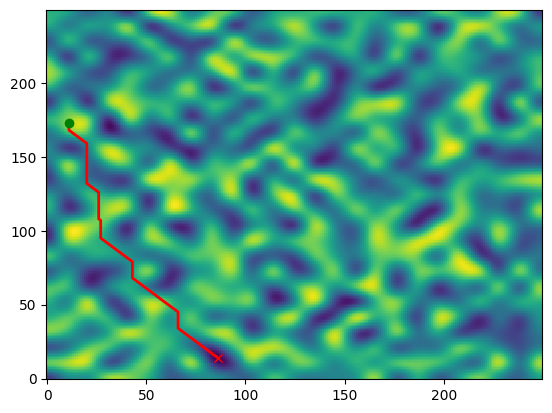

In [29]:
plot_matrix_with_path(interpolated_matrix, path)